In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
# EONET API Base URL 
BASE_URL = "https://eonet.gsfc.nasa.gov/api/v3/"


Data Wrangling - Get the Data from Eonet

The first step of the project is to "wrangle" the data, using NASA's EONET API to fetch raw disaster event data. Subsequently, this data is cleaned and transformed into an analyzable format, stored in a csv file (locally). 

The fetch_events function retrieves the data from NASA, using pagination to get the data in chunks, ensuring that I do not get rate limited by NASA's API. In addition, this function is set up so that we only focus on events in North America as well as specific categories, shown below in the DISASTER_CATEGORIES list. 

The cleaning process occurs in the processs_events_data funtion. This looks complicated but is intuitive and a result of all the different gemetry types NASA's API returns. For several disaster types, the API does not give a single latitude,longitude set but rather a polygon or lineshape. Thus, we need to normalize all these, and I used some basic geometry to find the centers of these different geometry types. These data points are then put in a csv file, utilizing the python main method.


In [11]:

# List of all disaster types provided by eonet (-wildfires)
DISASTER_CATEGORIES = [
    "drought", "dustHaze", "earthquakes", "floods", "landslides",
    "manmade", "seaLakeIce", "severeStorms", "snow", "tempExtremes",
    "volcanoes", "waterColor"
]

# Fetch Events for a Specific Category
def fetch_events(category, status, days, bbox, limit):
    url = f"{BASE_URL}events" #grab the global URL variable and use it as the endpoint
    all_events = [] # list for all events
    offset = 0 #utilize pagination as some of the events have quite a few occureences, allows us to grab it in chunks

    while True:
        #api request params
        params = {
            "status": status, #events are either open or closed
            "days": days, #how far back we hope to go
            "category": category, # type of disaseters
            "bbox": bbox, #bounding box, we are using NA
            "limit": limit, # number of events in request (1000)
            "offset": offset #offset so we can paginate, grab data in chunks
        }
        response = requests.get(url, params=params) #send req
        
        if response.status_code == 200: # if 200 code (fetched) then we parse the json

            data = response.json()
            events = data.get('events', [])

            # Stop pagination if we retrieve 0 events or events that are less than the limit
            if not events or len(events) < limit:
                print("No more events for category- ",category)
                all_events.extend(process_event_data(events)) #process the current events we grabbed
                break 
            
            #process/store fetched events
            all_events.extend(process_event_data(events))
            print("Fetched ",len(events), " events with offset,",offset ,"for category: ",category)
            offset += limit #add to offset to remain current

            time.sleep(1)  # Prevent hitting rate limits

        elif response.status_code == 429: #we have been rate limite dRIP
            print("Rate limied")
            break
        #error checking
        else:
            print("Error ",response.status_code," for category", category ," ", response.text)
            break
    
    return all_events

#process each event, clean them 
def process_event_data(events):
    
    processed_events = []  # to store all processed events

    for event in events:
        for geo in event['geometry']:  # Go through each event's geometry
            
            # Handle Point geometry type
            if geo['type'] == 'Point':
                processed_events.append({
                    "id": event['id'],  # Event ID
                    "title": event['title'],  # Name of the event
                    "category": event['categories'][0]['title'],  # Category of event
                    "date": geo['date'],  # Event date
                    "type": geo['type'],  # Type of event (geometry)
                    "longitude": geo['coordinates'][0] if len(geo['coordinates']) > 0 else None,
                    "latitude": geo['coordinates'][1] if len(geo['coordinates']) > 1 else None,
                    "geometry_count": len(event['geometry'])  # Length of the geometries
                })

            # Handle Polygon geometry type (calculate center)
            elif geo['type'] == 'Polygon':
    
                polygon = geo['coordinates'][0]  #use first point - assume that this is the exterior 
    

                if len(polygon) > 0:
                    longitude = sum([point[0] for point in polygon]) / len(polygon)  # Average longitude
                    latitude = sum([point[1] for point in polygon]) / len(polygon)  # Average latitude
                   
                    processed_events.append({
                        "id": event['id'],
                        "title": event['title'],
                        "category": event['categories'][0]['title'],
                        "date": geo['date'],
                        "type": geo['type'],
                        "longitude": longitude,
                        "latitude": latitude,
                        "geometry_count": len(event['geometry'])
                    })

            # Handle LineString geometry type (use midpoint)
            elif geo['type'] == 'LineString':
                
                linestring = geo['coordinates']
                
                if len(linestring) > 1:
                    mid_index = len(linestring) // 2  # Find the midpoint of the LineString
                    
                    longitude = linestring[mid_index][0]
                    latitude = linestring[mid_index[1]]
                    
                    processed_events.append({
                        "id": event['id'],
                        "title": event['title'],
                        "category": event['categories'][0]['title'],
                        "date": geo['date'],
                        "type": geo['type'],
                        "longitude": longitude,
                        "latitude": latitude,
                        "geometry_count": len(event['geometry'])
                    })

            #Handle MultiLineStrings geometry (use center of first LineString)
            elif geo['type'] == 'MultiLineString':
                
                multiline = geo['coordinates']
                
                if len(multiline) > 0 and len(multiline[0]) > 1: # Needs 2 booleans so we dont divide by 1
                    
                    mid_index = len(multiline[0]) // 2  # Use the midpoint of the first LineString
                    longitude, latitude = multiline[0][mid_index]
                   
                    processed_events.append({
                        "id": event['id'],
                        "title": event['title'],
                        "category": event['categories'][0]['title'],
                        "date": geo['date'],
                        "type": geo['type'],
                        "longitude": longitude,
                        "latitude": latitude,
                        "geometry_count": len(event['geometry'])
                    })
            
             # Handle MultiPolygon geometry (calculate center by turning all points into a single list)
            elif geo['type'] == 'MultiPolygon':
                multipolygon = geo['coordinates']

                # Flatten all polygons into a single list of points
                all_points = [point for polygon in multipolygon for ring in polygon for point in ring]
                
                if len(all_points) > 0: # use center
                    mid_longitude = sum(point[0] for point in all_points) / len(all_points)
                    mid_latitude = sum(point[1] for point in all_points) / len(all_points)
                   
                    processed_events.append({
                        "id": event['id'],
                        "title": event['title'],
                        "category": event['categories'][0]['title'],
                        "date": geo['date'],
                        "type": geo['type'],
                        "longitude": longitude,
                        "latitude": latitude,
                        "geometry_count": len(event['geometry'])
                    })
    return processed_events


if __name__ == "__main__":
   
    output_file = "all_disasters_10_years.csv"  # Output file name
    data = []  # List to store all processed events

    # Fetch events for each category
    for category in DISASTER_CATEGORIES:
        print("Fetching events for category - ", category)
        category_events = fetch_events(category, 'closed', 3650, "-170.0,10.0,-50.0,70.0"  , 1000) # Params outlined in the function 
        data.extend(category_events)


    # Save all events into a CSV file
    if data:
        df = pd.DataFrame(data)
        df.to_csv(output_file, index=False)
        print("Saved ",len(df)," events to ",output_file)
    else:
        print("No events found")

    print("Finished fetching and writing data")

Fetching events for category -  drought
No more events for category-  drought
Fetching events for category -  dustHaze
No more events for category-  dustHaze
Fetching events for category -  earthquakes
No more events for category-  earthquakes
Fetching events for category -  floods
No more events for category-  floods
Fetching events for category -  landslides
No more events for category-  landslides
Fetching events for category -  manmade
No more events for category-  manmade
Fetching events for category -  seaLakeIce
No more events for category-  seaLakeIce
Fetching events for category -  severeStorms
No more events for category-  severeStorms
Fetching events for category -  snow
No more events for category-  snow
Fetching events for category -  tempExtremes
No more events for category-  tempExtremes
Fetching events for category -  volcanoes
No more events for category-  volcanoes
Fetching events for category -  waterColor
No more events for category-  waterColor
Saved  6757  events 

Summary Stats

This step was about exploratory data analysis to understand the distribution of events by category. I used basic summary statistics to create a barplot visualization, showing the frequency of disaster types over the last 10 years. This basic analysis shows that the data I have is significantly imbalaned, as there is a significant amount of Severe Storms, and not a proportional amount of the other categories. It is important to note this now, early on in the data analysis as it will skew future results.  

Event Count by Category:
category
Severe Storms           6652
Volcanoes                 76
Floods                    16
Water Color                7
Earthquakes                3
Temperature Extremes       2
Sea and Lake Ice           1
Name: count, dtype: int64


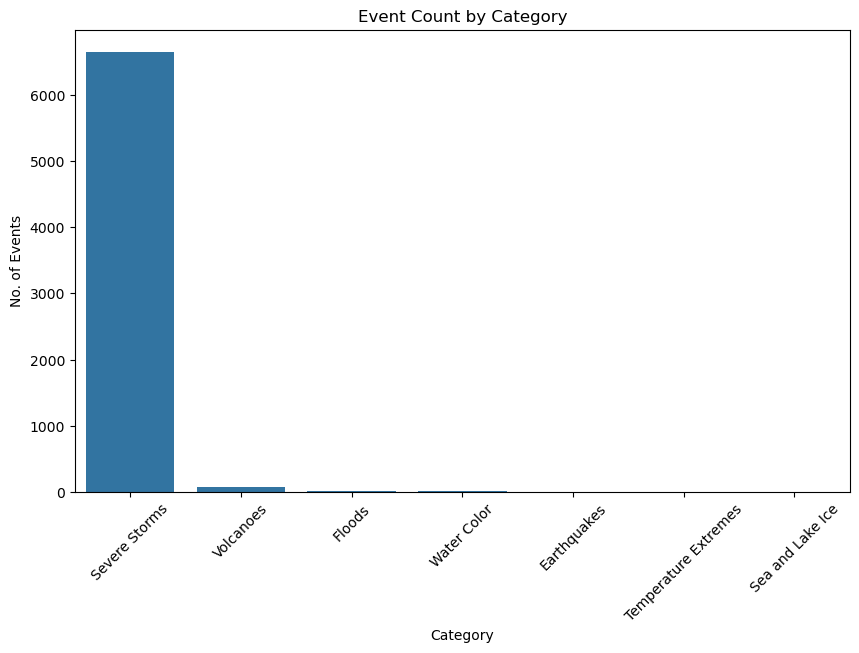

In [12]:
file_path = "all_disasters_10_years.csv"
df = pd.read_csv(file_path)

# Count events by category
counts = df['category'].value_counts()

# Print summary
print("Event Count by Category:")
print(counts)

# Bar plot for category counts
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Event Count by Category")
plt.xlabel("Category")
plt.ylabel("No. of Events")
plt.xticks(rotation=45) # Makes it less crowded, tilts the labels
plt.show()

Heatmap Analysis :
The next data visualization deals with the idea of seeing trends over time in relation to natural disasters. To accomplish this I used heatmaps over time, and only plotted those which have more than 10 events as it will be more credible this way. Based off the results, we can see that there are some slight trends, particularly in the severe storms heatmap. Here, we can see that there tends to be more activity around July - September, which tracks with knowledge on how storms form etc. We can also see the lack of trends in an event such as volcanes, which has a spareselt populated heatmap with no distinct "hotspots" when it comes to disasters.   

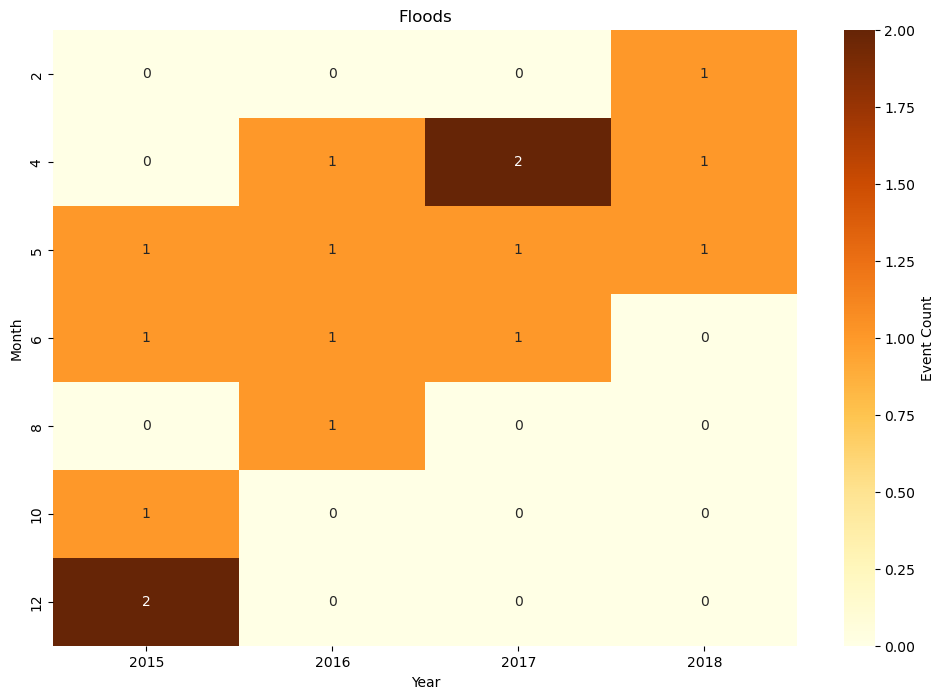

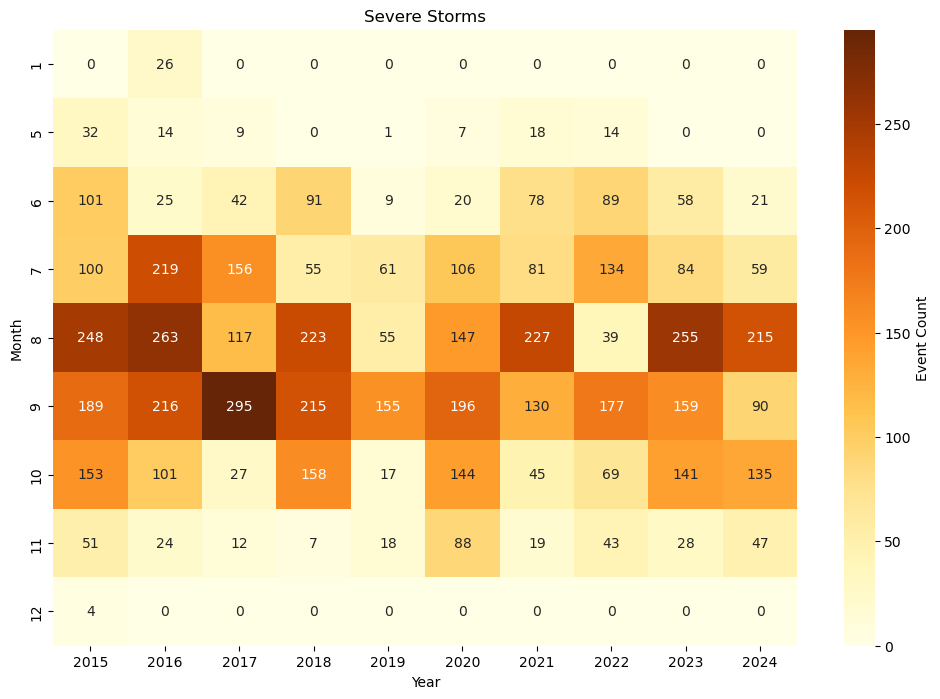

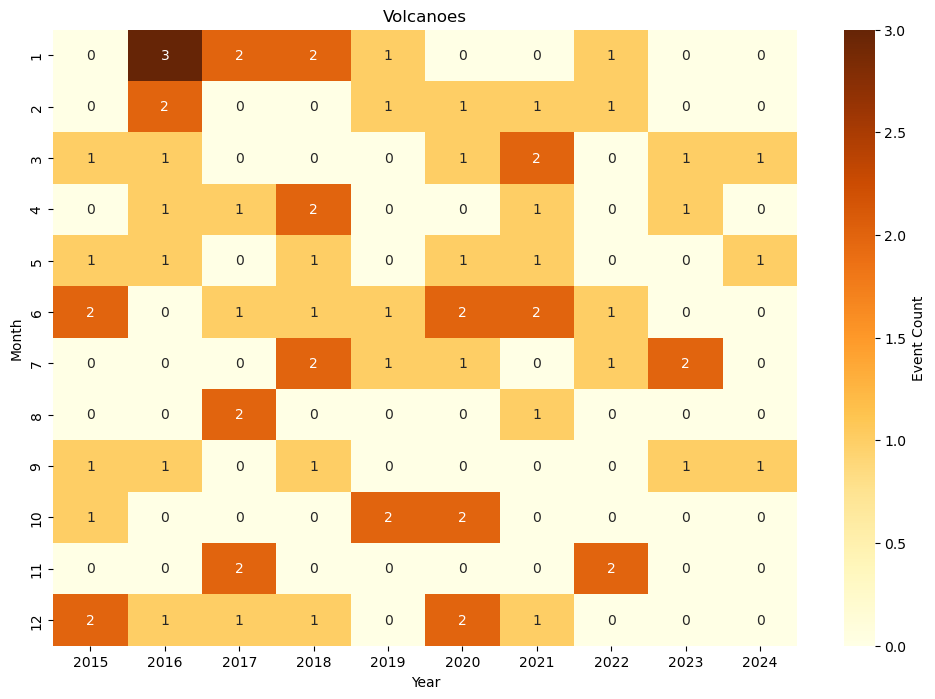

In [13]:
# Convert date column to datetime, using datetime
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Group data by category, year, and month, then use .size() to get the count, and use reset_index to put this count as a new column 
temporal_Data = (df.groupby(['category', 'year', 'month']).size().reset_index(name='event_count'))


# Filter categories with total events > 10
totals = temporal_Data.groupby('category')['event_count'].sum().reset_index()
categories = totals[totals['event_count'] > 10]['category'].tolist()


# Iterate through each category 
for category in categories:
    # Boolean mask to aquire date strictly from current category 
    curr_df = temporal_Data[temporal_Data['category'] == category]
    
    # Reshapes table for heatmap format, putting month as the rows and years as the columns, event count is the value that goes in the cells 
    pivot_df = curr_df.pivot(index='month', columns='year', values='event_count').fillna(0) # Ran into a few errors where I kept getting NA values and fixed it using fillNA to fill missing with 0
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, cmap="YlOrBr", annot=True, fmt=".0f", cbar_kws={'label': 'Event Count'}) # cmap changes color pallete, annot adds annotations and fmt is the format for values, cbar edits the legend 
    plt.title(category)
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.show()

Geospatial Visualization

Here we use mapbox to create a geospatial visualization that shows disaster event hotspots. We get rid of duplicates and normalize the df to find these 'hotspots'. It is important to note that we dont display the magnitude of events. Additionally, the bounding box we use shows its limitations as it is a square of north america but we are using the mercator projection on the background so our dimensisons seem slishglty warped/ 

In [14]:
file_path = "all_disasters_10_years.csv"  # Grab the local file path 
df = pd.read_csv(file_path) # Read the CSV


# The dataset has duplicates for events such as storms as they occur over time, this is an issue that we solve by normalizing the data
normalized_df = df.groupby('id', as_index=False).agg({
    'title': 'first', #First occurence of title
    'category': 'first', # First occurence of the categiory  
    'date': 'first', # First occurence of the date
    'latitude': 'mean', # Mean of the latitudes
    'longitude': 'mean', # Mean of the longitudes
    'geometry_count': 'sum' # Count of all the geometry incase we want to show magngitude 
})


def plot_scatter_mapbox(df):
    fig = px.scatter_mapbox( #Use the mapbox, similar to previous homework
        df, # Data
        lat="latitude", # Plot off of latitude and longitude
        lon="longitude",
        color="category",          # Different colors for each category to differentiate
        size_max=10,               # Set the max to 7  so that they dont crowd one another 
        size= [5]*len(df),        #    Statically set the size, ignore magnitude (mention in limitations) 
        hover_name="title",        # Show event title on hover
        hover_data=["date", "category"],  # Additional info
        mapbox_style="carto-positron",    # Mapbox background style
        title="Disaster Event Hotspots",
        zoom=3,                    # Initial zoom level
        center={"lat": 37.0, "lon": -95.0}  # Centered on the U.S.
    )
    fig.update_layout(
        width=1600,                     
        height=800,                     
        margin={"r":0, "t":50, "l":0, "b":0},  
        mapbox_zoom=2.5                    # Adjust initial zoom
    )

    fig.show()

plot_scatter_mapbox(normalized_df)

ML Predictions

In this step I utilized K-Nearest Neighbors (KNN) algorithm to classify disaster events into different categories based off their coordinates and other features. KNN was chosen as it is simple, I have a good grasp on it and it should be effective as classification problems. By training this model on historical data of the last 10 years we are allowing the model to properly predict future events. The result is a mapbox visualization, similar to previous visualizations. However, we can see the dominance of Severe Storms in the datasets, as the model predicts almost every future event as that, and the map is still filled with severe storm warnings. The model is a reflection of the dataset we have and is able to showcase a certain affinity in future event prediction. 

In [15]:
# Load the dataset
file_path = "all_disasters_10_years.csv"
df = pd.read_csv(file_path)


# Convert categories such as volvanes into numbers
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category']) 

# Features (latitude, longitude, geometry_count) and target (category)
X = df[['latitude', 'longitude', 'geometry_count']]
y = df['category_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features so that we have a mean of 0 and a standard deviation of 1, equalizes weights of data points - important as we are using an imabalanced data set 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# KNN model with k=5 (can be optimized but this seems best )
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, y_train)

# Predict on the test
y_pred = knn.predict(X_test_scaled)


KNN Model Accuracy:  0.992603550295858
Classification matrice
                      precision    recall  f1-score   support

              Floods       0.00      0.00      0.00         4
    Sea and Lake Ice       0.00      0.00      0.00         1
       Severe Storms       0.99      1.00      1.00      1332
Temperature Extremes       0.00      0.00      0.00         1
           Volcanoes       0.83      0.83      0.83        12
         Water Color       0.50      0.50      0.50         2

            accuracy                           0.99      1352
           macro avg       0.39      0.39      0.39      1352
        weighted avg       0.99      0.99      0.99      1352

Confusion matrix - 


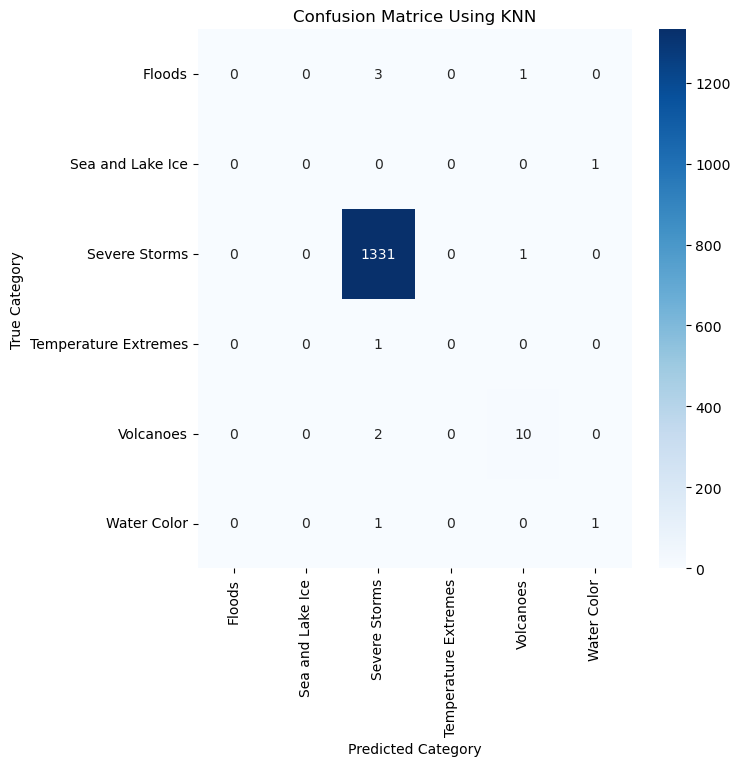

In [17]:
unique_classes = np.unique(y_test) # Extract unique categories, since our data set is imbalanced we need to do this to make sure all categories are used in the confusion matrice
disaster_names = label_encoder.inverse_transform(unique_classes) # Inverses the label encoding to turn them back into categorical values from numerical

# Calculate accuracy - proportion of correctly predicted labels
accuracy = accuracy_score(y_test, y_pred)
print("KNN Model Accuracy: ", accuracy)

# Classification report 
print("Classification matrice")
print(classification_report(y_test, y_pred, target_names=disaster_names,zero_division=0)) # Target names parameter ensures we get respective names, zero division issue pops up due to the imbalance as well

# Confusion Matrix
# Print confusion matrix with decoded labels
print("Confusion matrix - ")
conf_matrix = confusion_matrix(y_test, y_pred, labels= unique_classes) # Use numeric values not the vategorical names

#visualize the Confusion matrice
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=disaster_names, yticklabels=disaster_names) # Fmt = d means whole integers, and cMap means pallete of blue 
plt.title("Confusion Matrice Using KNN")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.show()



Based off the confusion matrix and the accuracy score, we can see that the sever eimbalance has affected the KNN model even if the overall accuracy is good it is a result of the dominance of Severe Storms. The model can not perform well when using minority classes, and just puts them all as severe storms. 

In [18]:

X_test['predicted_category'] = label_encoder.inverse_transform(y_pred) # Reverse encode again

# Plot the test predictions on a Mapbox scatter plot - same code as before essentially
fig = px.scatter_mapbox(
    X_test,
    lat="latitude",                    # Latitude and Longitude for plotting
    lon="longitude",                   
    color="predicted_category",        # Color based on predicted category
    hover_name="predicted_category",   # Show predicted category name
    size_max=10,                       # Maximum marker size
    size=[5] * len(X_test),            # Static size for all points 
    mapbox_style="carto-positron",     # Mapbox background style
    title="Predicted Disaster Categories - KNN",
    zoom=3,                            # Initial zoom level
    center={"lat": 37.0, "lon": -95.0} # Centered on the US

)
    
fig.update_layout(
        width=1600,                     
        height=800,                     
        margin={"r":0, "t":50, "l":0, "b":0},  
        mapbox_zoom=2.5                    # Adjust initial zoom
    )        
fig.show()


Based off this map, we can see that the model does seem correct visually, specifically when it comes to severe storms